# Временные ряды

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

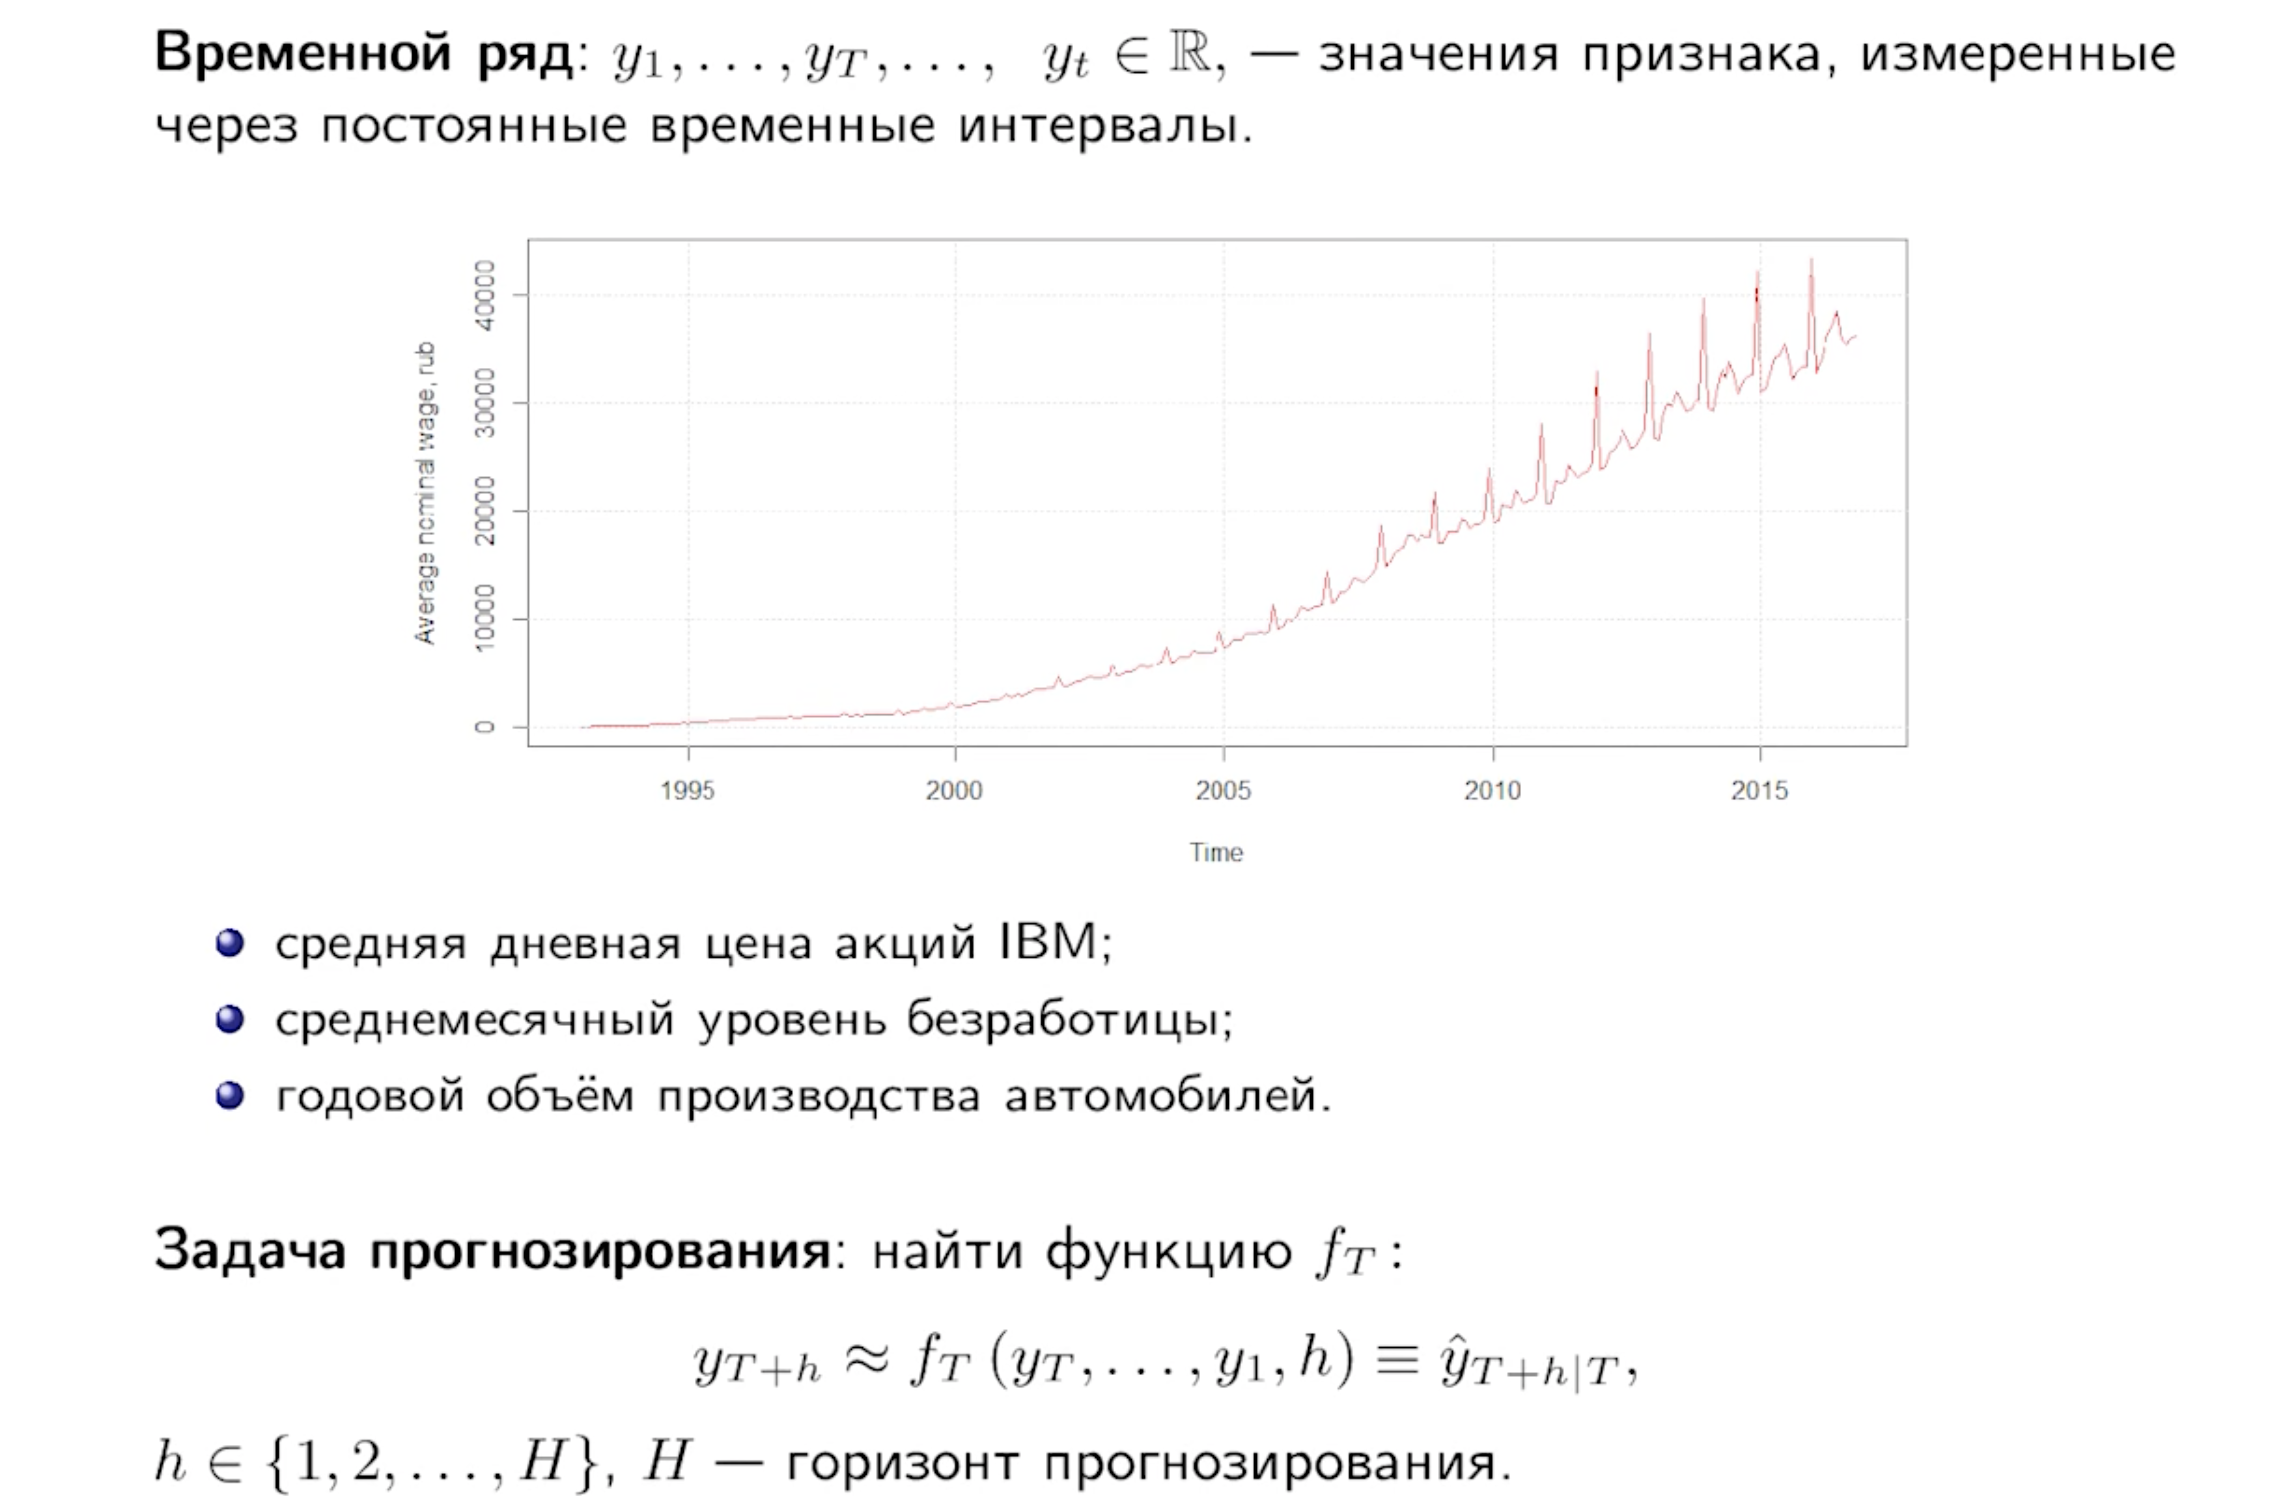

In [3]:
Image('images/tsintro.png', width=600)

In [3]:
data = pd.read_csv('data/tsla.us.txt').drop(columns=['OpenInt'])
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-28,17.00,17.00,17.00,17.00,0
2010-06-29,19.00,25.00,17.54,23.89,18783276
2010-06-30,25.79,30.42,23.30,23.83,17194394
2010-07-01,25.00,25.92,20.27,21.96,8229863
2010-07-02,23.00,23.10,18.71,19.20,5141807


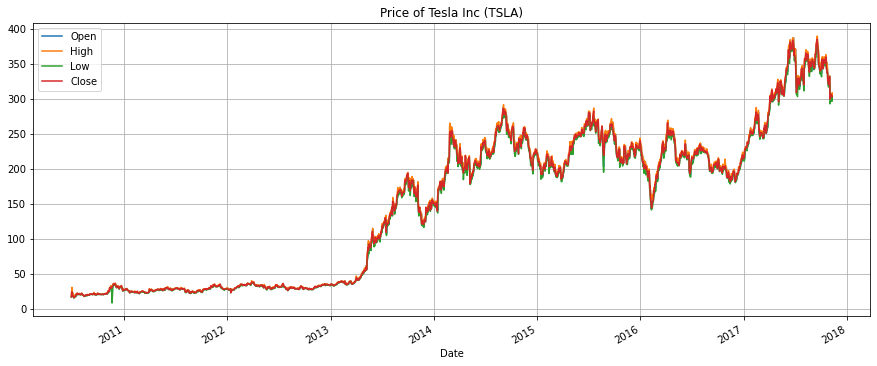

In [4]:
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

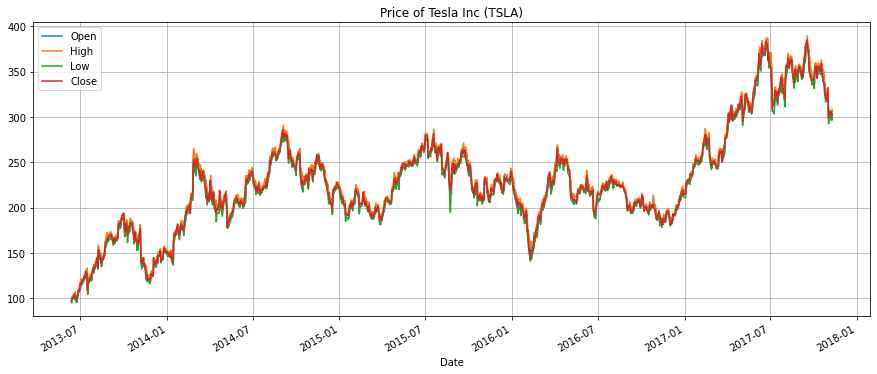

In [5]:
data = data.iloc[int(len(data)*0.4):]
data[['Open', 'High', 'Low', 'Close']].plot(figsize=(15, 6), 
                                            title='Price of Tesla Inc (TSLA)')
plt.grid()

## Daily return
Сколько заработаем, если вчера вечером купили, а сегодня вечером продадим.

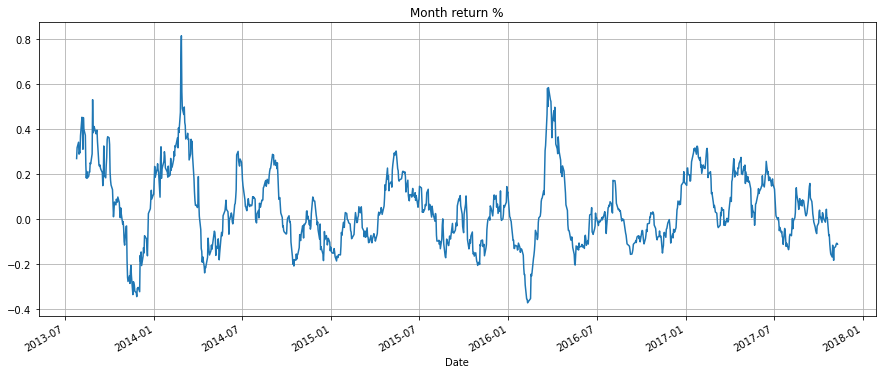

In [7]:
data['Daily return'] = data['Close'].pct_change(periods=30)
data['Daily return'].plot(figsize=((15,6)), title='Month return %')
plt.grid()

/Users/stihin/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


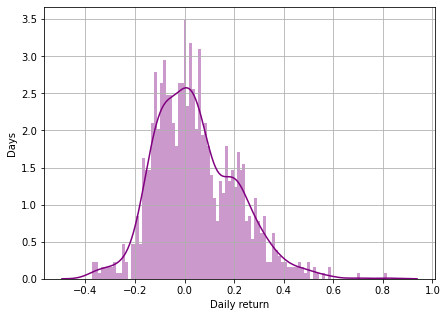

In [8]:
plt.figure(figsize=(7,5))
sns.distplot(data['Daily return'].dropna(), bins=100, color='purple')
plt.ylabel('Days')
plt.grid()

## Постановка задачи

Пусть данные $y$ - некоторое значение параметра. 

Необходимо делать предсказание $y$ на будущее.

Основные отличия:

* Объекты **ЗАВИСИМЫ** в отличие от регресии/классификации/кластеризации.

* Возможно есть какие-то доп. пирзнаки для каждой даты, но обычно только дата.

Пока будем предсказывать $y_{t+1}$, потом посмотрим, что будем с горизонтом.

In [9]:
data['Close+1'] = data['Close'].shift(-1)
data['Close+5'] = data['Close'].shift(-5)
data['Close+10'] = data['Close'].shift(-10)

data = data[:-10]

In [10]:
data[['Close', 'Close+1', 'Close+5', 'Close+10']].tail(12)

,Close,Close+1,Close+5,Close+10
Date,,,,
2017-10-12,355.68,355.57,351.81,326.17
2017-10-13,355.57,350.60,345.10,320.87
2017-10-16,350.60,355.75,337.02,320.08
2017-10-17,355.75,359.65,337.34,331.53
2017-10-18,359.65,351.81,325.84,321.08
2017-10-19,351.81,345.10,326.17,299.26
2017-10-20,345.10,337.02,320.87,306.09
2017-10-23,337.02,337.34,320.08,302.78
2017-10-24,337.34,325.84,331.53,306.05


In [12]:
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

def result(data, sol_cols, targets=['Close+1', 'Close+10'], test_size=0.1):
    
    test_size = 0.1
    test_data = data[-int(len(data)*test_size):]
    for target in targets:
        title_ = target + ': '
        for sol in sol_cols:
            error = MSE(test_data[sol], test_data[target])
            title_ += '{0} MSE: {1:.2f}, '.format(sol, error)
        test_data[[target, *sol_cols]].plot(figsize=(15, 6), 
                                            title=title_)
        plt.grid()

## Решения

### 1. Очень тупое

$$y_{t+h} = y_{t}$$

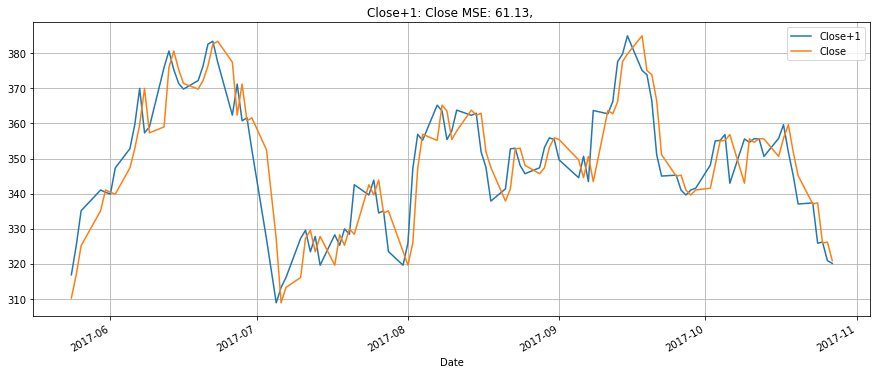

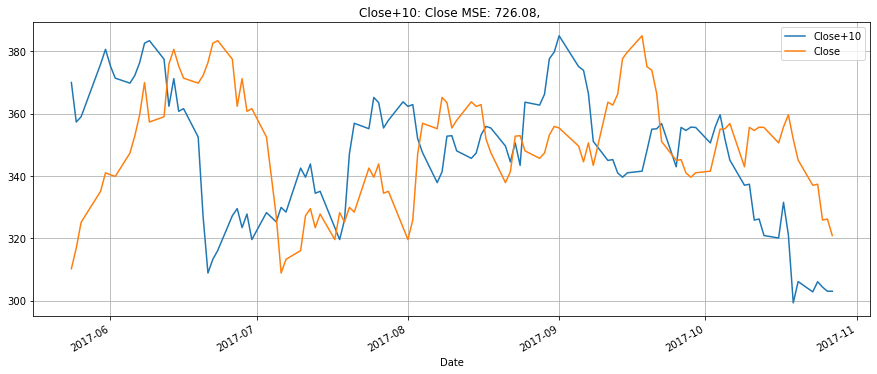

In [50]:
result(data, sol_cols = ['Close'])

### 2. Moving average (MA)

Скользящее среднее с окном длины $n$

$$\hat{y}_{t+1} = \frac{1}{n}\sum_{i=1}^{n}y_{t-i+1}$$

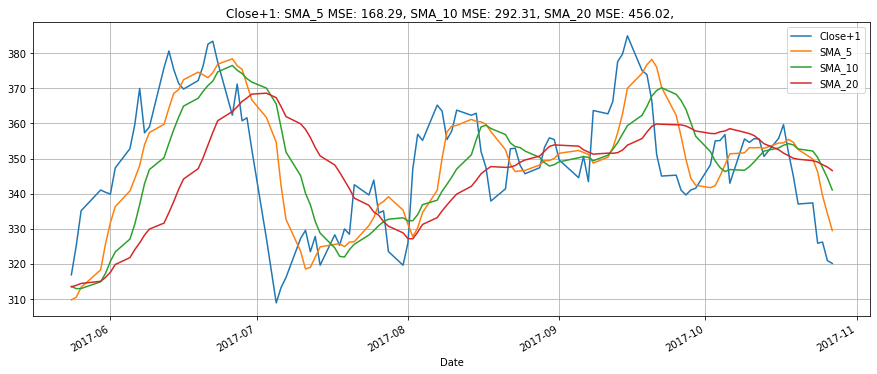

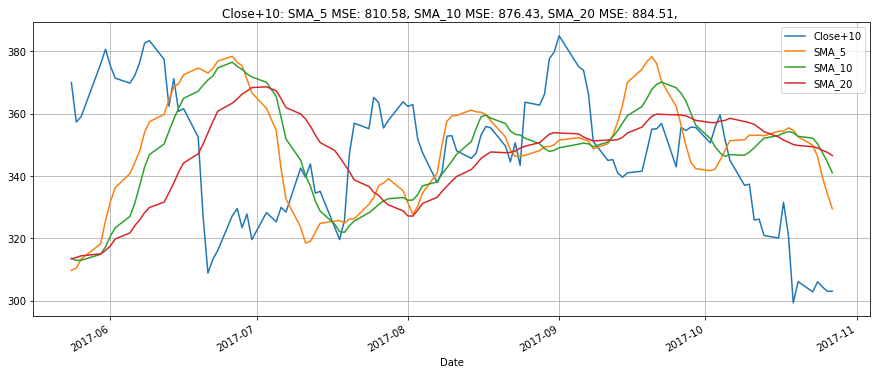

In [15]:
data['SMA_5']  = data['Close'].rolling(5).mean()
data['SMA_10'] = data['Close'].rolling(10).mean()
data['SMA_20'] = data['Close'].rolling(20).mean()

result(data, sol_cols = ['SMA_5','SMA_10', 'SMA_20'])

### 3. Exponential average

$$\hat{y}_{t+1} = \alpha \cdot y_t + (1-\alpha) \cdot \hat y_{t} $$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

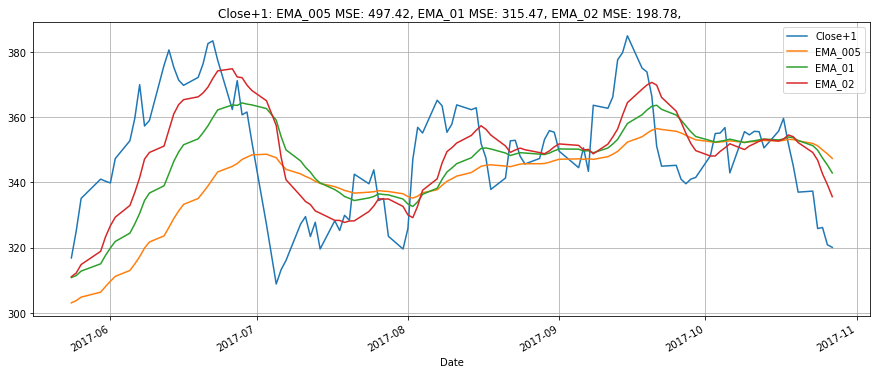

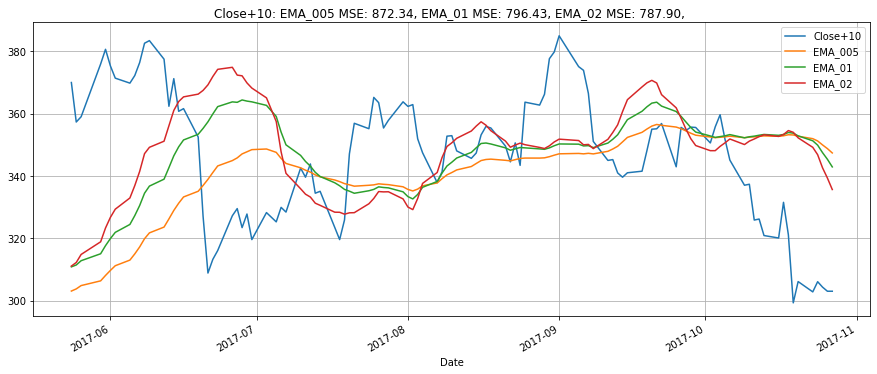

In [13]:
data['EMA_005'] = data['Close'].ewm(alpha=0.05).mean()
data['EMA_01']  = data['Close'].ewm(alpha=0.1).mean()
data['EMA_02']  = data['Close'].ewm(alpha=0.2).mean()


result(data, sol_cols = ['EMA_005', 'EMA_01', 'EMA_02'])

## 4. А давайте что-нибудь стандартное

In [16]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split

data_learn = data[600:]

X = data_learn[['Close','SMA_5','SMA_10', 'SMA_20', 'EMA_005', 'EMA_01', 'EMA_02']]
y1 = data_learn['Close+1']
y2 = data_learn['Close+10']


In [17]:

X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, shuffle=False)
                   
model1 = CatBoostRegressor(silent=True).fit(X_train, y_train)
                                                    
MSE(model1.predict(X_test), y_test)                                            

276.63487675510197

<ipython-input-20-95babf931d46>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['model1'] = np.hstack([np.zeros(505-101), model1.predict(X_test).reshape(-1)])


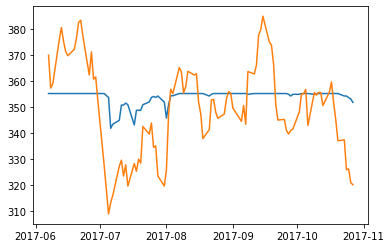

In [20]:
data_learn['model1'] = np.hstack([np.zeros(505-101), model1.predict(X_test).reshape(-1)])
plt.plot(data_learn[['model1', 'Close+1']][-101:])

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.2, shuffle=False)
                   
model2 = CatBoostRegressor(silent=True).fit(X_train, y_train)
                                                    
MSE(model2.predict(X_test), y_test)                                            

1153.7391766958692

<ipython-input-23-8025869886f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_learn['model2'] = np.hstack([np.zeros(505-101), model2.predict(X_test).reshape(-1)])


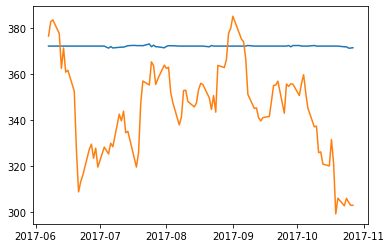

In [23]:
data_learn['model2'] = np.hstack([np.zeros(505-101), model2.predict(X_test).reshape(-1)])
plt.plot(data_learn[['model2', 'Close+10']][-101:])

## Метрики

In [102]:
from sklearn.metrics import max_error as ME, mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE

#### Max error

$$\text{Max Error}(y, \hat{y}) = max(| y_i - \hat{y}_i |)$$

In [97]:
ME(model1.predict(X_test), y_test)

55.957801702130155

#### Mean absolute error

$$\text{MAE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \left| y_i - \hat{y}_i \right|.$$

In [99]:
MAE(model1.predict(X_test), y_test)

16.70536332465368

#### Mean squared error

$$\text{MSE}(y, \hat{y}) = \frac{1}{n_\text{samples}} \sum_{i=0}^{n_\text{samples} - 1} (y_i - \hat{y}_i)^2.$$

In [100]:
MSE(model1.predict(X_test), y_test)

482.72250439603414

#### RMSE

In [101]:
MSE(model1.predict(X_test), y_test)**0.5

21.970946825206102

#### Mean absolute percentage error

$$\text{MAPE}(y, \hat{y}) = \frac{1}{n_{\text{samples}}} \sum_{i=0}^{n_{\text{samples}}-1} \frac{{}\left| y_i - \hat{y}_i \right|}{max(\epsilon, \left| y_i \right|)}$$

In [103]:
MAPE(model1.predict(X_test), y_test)

0.04718764634439469

## Декомпозиция

In [121]:
new_data = pd.read_csv('data/airplanes.txt')